# Utilisation du transfert learning pour classer les images capturées

## Récupération et traitement des données

Utilisation des photos de bouteilles et de cannettes pour former un dataset et séparation du dataset en un jeu d'entrainement et un jeu de test. 

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms

# Dataset personnalisé sans transformation
class CustomImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_map = {"bottle": 0, "canette": 1}  # Labels numériques

        for class_name, label in self.class_map.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):  # Vérifier que le dossier existe
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.lower().endswith(("png", "jpg", "jpeg")):  # Filtrer les images
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Charger l'image en couleur
        label = self.labels[idx]
        return image, label  # Retourne une image PIL et un label

# Création du dataset brut
dataset = CustomImageDataset(root_dir="data")

In [33]:
# Séparation en train/test (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Train: {len(train_dataset)} images, Test: {len(test_dataset)} images")

Train: 290 images, Test: 73 images


## Classement avec VGG16

Chargement de VGG16 pré-entrainé puis entrainement avec nos images.

In [18]:
# Chargement de VGG16
import torch
import torch.nn as nn
import torchvision.models as models

# Charger le modèle VGG16 pré-entraîné
model = models.vgg16(pretrained=True)

# Geler toutes les couches du modèle (on ne les entraîne pas)
for param in model.features.parameters():
    param.requires_grad = False

# Modifier la dernière couche pour avoir 2 classes (bouteilles et canettes)
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # 2 classes

# Envoyer le modèle sur GPU si disponible
device = torch.device("cpu")
model = model.to(device)

print(model)


/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/am/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
# Transformations spécifiques pour VGG16
vgg16_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Taille requise par VGG16
    transforms.ToTensor(),  # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Appliquer les transformations avec un `collate_fn`
def collate_fn(batch):
    images, labels = zip(*batch)  # Séparer images et labels
    images = [vgg16_transform(img) for img in images]  # Appliquer transformation
    return torch.stack(images), torch.tensor(labels)

# DataLoaders avec batch_size=32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Vérification du DataLoader
images, labels = next(iter(train_loader))
print(f"Batch de {len(images)} images chargé avec taille {images.shape}")


Batch de 32 images chargé avec taille torch.Size([32, 3, 224, 224])


In [36]:
# Selection de l'optimiseur et de la fonction de perte

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)


In [37]:
# Entraînement du modèle

num_epochs = 5  # Nombre d'époques d'entraînement

for epoch in range(num_epochs):
    model.train()  # Mode entraînement
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(images)  # Prédictions du modèle
        loss = criterion(outputs, labels)  # Calcul de la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

print("Entraînement terminé ! 🎉")


Epoch 1/5, Loss: 0.5946592897176742
Epoch 2/5, Loss: 0.2536013647913933
Epoch 3/5, Loss: 0.17440512031316757
Epoch 4/5, Loss: 0.11649434715509414
Epoch 5/5, Loss: 0.10705026164650917
Entraînement terminé ! 🎉


In [ ]:
# Evaluation du modèle

from sklearn.metrics import accuracy_score

model.eval()  # Mode évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Précision du modèle VGG16: {accuracy:.4f}")

# Sauvegarde du modèle
torch.save(model.state_dict(), "model_VGG16.pth")
accuracy_vgg16 = accuracy



Précision du modèle VGG16: 0.9897


In [41]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Verification du dataLoader
images, labels = next(iter(test_loader))
print(f"Batch de {len(images)} images chargé avec taille {images.shape}")


Batch de 32 images chargé avec taille torch.Size([32, 3, 224, 224])


In [ ]:
# Evaluation du modèle sur le jeu de test 
model.eval()  # Mode évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Précision du modèle VGG16: {accuracy:.4f}")


Précision du modèle VGG16: 1.0000


## Classement avec DenseNet121

In [43]:
# Transformation des données 

# Transformations spécifiques pour DenseNet121
densenet121_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Taille requise par DenseNet121
    transforms.ToTensor(),  # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Appliquer les transformations avec un `collate_fn`
def collate_fn(batch):
    images, labels = zip(*batch)  # Séparer images et labels
    images = [densenet121_transform(img) for img in images]  # Appliquer transformation
    return torch.stack(images), torch.tensor(labels)

# DataLoaders avec batch_size=32
train_loader_densenet121 = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_densenet121 = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Vérification du DataLoader
images, labels = next(iter(train_loader_densenet121))
print(f"Batch de {len(images)} images chargé avec taille {images.shape}")

Batch de 32 images chargé avec taille torch.Size([32, 3, 224, 224])


In [44]:
# Charger le modèle DenseNet121 pré-entraîné
model = models.densenet121(pretrained=True)

# Modifier la dernière couche pour correspondre à notre nombre de classes (2: "bottle" et "canette")
model.classifier = nn.Linear(model.classifier.in_features, 2)  # 2 classes

# Déplacer le modèle sur le bon appareil (GPU si disponible, sinon CPU)
device = torch.device("cpu")
model = model.to(device)

/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/am/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100.0%


In [45]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
# Entraînement du modèle
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Passer en mode entraînement
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Remise à zéro des gradients
        outputs = model(images)  # Prédictions
        loss = criterion(outputs, labels)  # Calcul de la perte
        loss.backward()  # Backpropagation
        optimizer.step()  # Mise à jour des poids
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/10], Loss: 0.1169
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0816
Epoch [4/10], Loss: 0.0808
Epoch [5/10], Loss: 0.0648
Epoch [6/10], Loss: 0.0068
Epoch [7/10], Loss: 0.0029
Epoch [8/10], Loss: 0.0061
Epoch [9/10], Loss: 0.0196
Epoch [10/10], Loss: 0.0117


In [48]:
# Évaluation du modèle
model.eval()  # Mode évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Précision du modèle DenseNet121: {accuracy:.4f}")

Précision du modèle DenseNet121: 1.0000


In [ ]:
# Évaluation du modèle sur le jeu de test
model.eval()  # Mode évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Précision du modèle DenseNet121: {accuracy:.4f}")

# Sauvegarde du modèle
torch.save(model.state_dict(), "model_DenseNet121.pth")
accuracy_densenet121 = accuracy

Précision du modèle DenseNet121: 1.0000


## Exemple d'utilisation avec DenseNet121

/home/raspac/.yolo_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raspac/.yolo_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/raspac/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [05:30<00:00, 1.67MB/s] 
/home/raspac/.yolo_venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecat

Prédiction VGG16: canette
Prédiction DenseNet121: canette


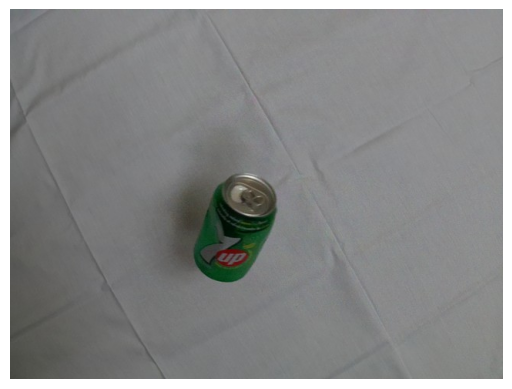

In [1]:
# Importation des librairies
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torchvision import models


# Lecture d'une image
img = Image.open("mouvement_12.jpg")

# Transformation pour VGG16
vgg16_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformation pour DenseNet121
densenet121_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Application des transformations
img_vgg16 = vgg16_transform(img)
img_densenet121 = densenet121_transform(img)

# Ajout d'une dimension pour le batch
img_vgg16 = img_vgg16.unsqueeze(0)
img_densenet121 = img_densenet121.unsqueeze(0)

# Prédiction avec VGG16
model_vgg16 = models.vgg16(pretrained=True)
num_features = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_features, 2)
model_vgg16.load_state_dict(torch.load("model_VGG16.pth"))
model_vgg16.eval()
with torch.no_grad():
    output_vgg16 = model_vgg16(img_vgg16)
    _, pred_vgg16 = torch.max(output_vgg16, 1)

# Prédiction avec DenseNet121
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier = nn.Linear(model_densenet121.classifier.in_features, 2)
model_densenet121.load_state_dict(torch.load("model_DenseNet121.pth"))
model_densenet121.eval()
with torch.no_grad():
    output_densenet121 = model_densenet121(img_densenet121)
    _, pred_densenet121 = torch.max(output_densenet121, 1)

# Affichage des prédictions
class_map = {0: "bouteille", 1: "canette"}
print(f"Prédiction VGG16: {class_map[pred_vgg16.item()]}")
print(f"Prédiction DenseNet121: {class_map[pred_densenet121.item()]}")

# Affichage de l'image
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis("off")
plt.show()



[1:13:14.988552312] [4797]  INFO Camera camera.cpp:1202 configuring streams: (0) 640x480-RGB888 (1) 1456x1088-BGGR_PISP_COMP1
[1:13:14.988772497] [4586]  INFO RPI pisp.cpp:1484 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B


Mouvement détecté! Prise de photo en rafale.
Photo 1 enregistrée sous mouvement_1.jpg
Photo 2 enregistrée sous mouvement_2.jpg
Photo 3 enregistrée sous mouvement_3.jpg
Photo 4 enregistrée sous mouvement_4.jpg
Photo 5 enregistrée sous mouvement_5.jpg
Mouvement détecté! Prise de photo en rafale.
Photo 1 enregistrée sous mouvement_6.jpg
Photo 2 enregistrée sous mouvement_7.jpg
Photo 3 enregistrée sous mouvement_8.jpg
Photo 4 enregistrée sous mouvement_9.jpg
Photo 5 enregistrée sous mouvement_10.jpg
Prédiction VGG16: bouteille
Prédiction DenseNet121: canette


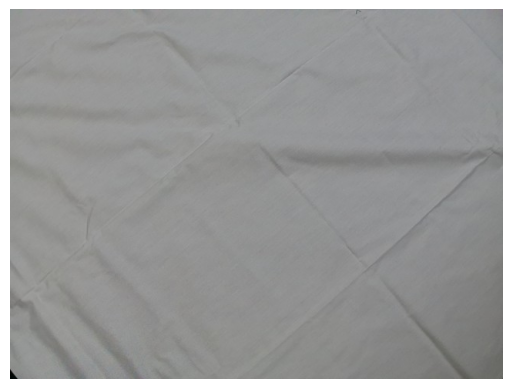

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


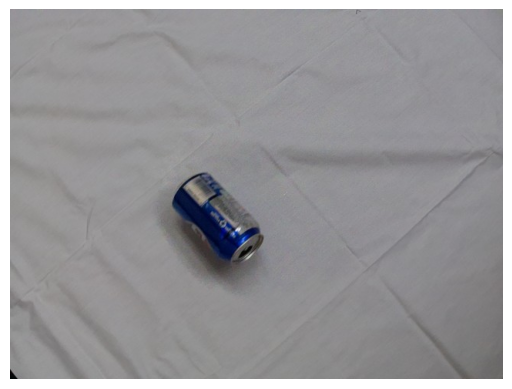

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


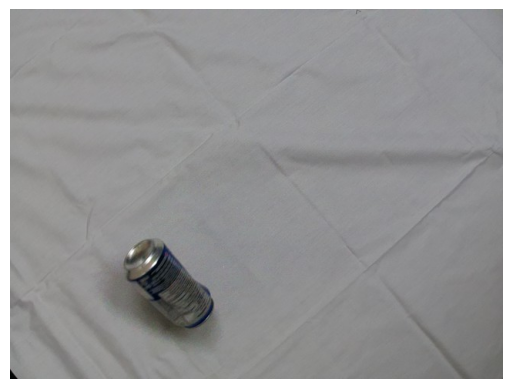

Prédiction VGG16: bouteille
Prédiction DenseNet121: canette


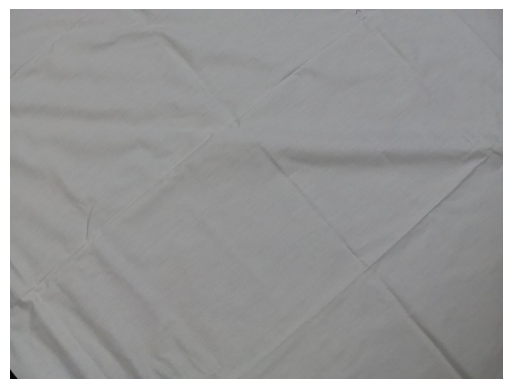

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


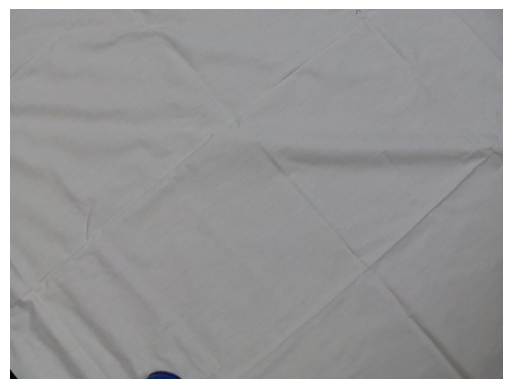

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


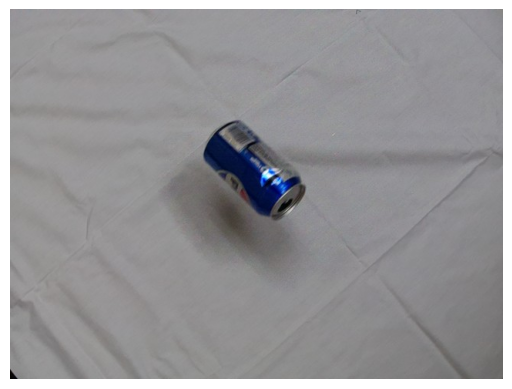

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


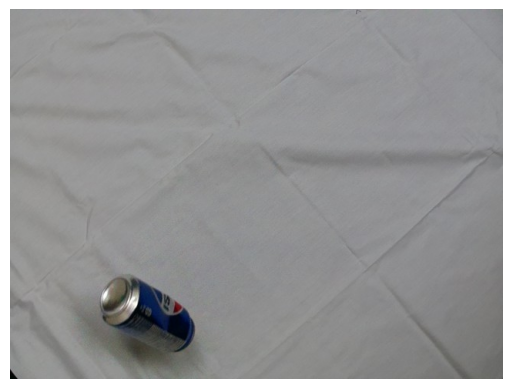

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


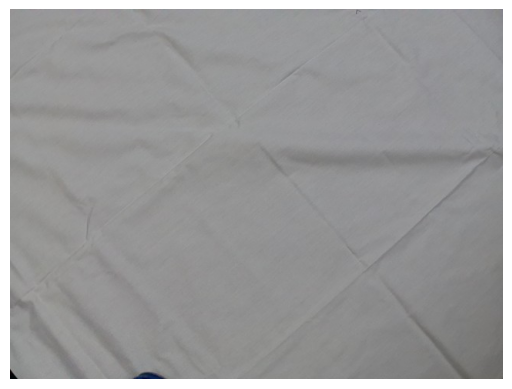

Prédiction VGG16: bouteille
Prédiction DenseNet121: canette


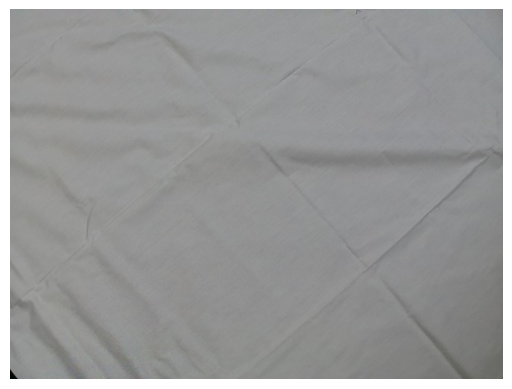

Prédiction VGG16: bouteille
Prédiction DenseNet121: bouteille


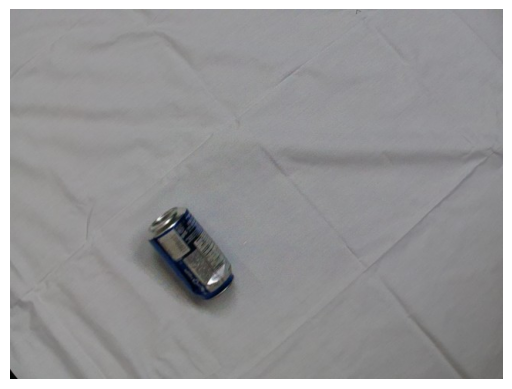

In [21]:
import numpy as np
import time
from picamera2 import Picamera2
import cv2
import os

# Initialiser la caméra
picam2 = Picamera2()

# Configuration de la caméra pour obtenir une image en RGB
video_config = picam2.create_video_configuration(main={"size": (640, 480), "format": "RGB888"})
picam2.configure(video_config)
picam2.start()

# Variables pour le calcul du mouvement
prev_frame = None
motion_threshold = 6000  # Valeur seuil pour détecter le mouvement
ltime = time.time()
photo_taken_time = 0  # Variable pour garder la trace du moment où une photo a été prise
photo_delay = 0.05  # Temps d'attente en secondes avant de permettre un nouveau mode burst
timestamp = 0

# Paramètres du mode burst
burst_count = 5  # Nombre d'images à prendre en rafale
burst_delay = 0.001  # Délai entre chaque prise d'image en rafale (en secondes)

picam2.set_controls({"ExposureTime": 1500})
while True and timestamp<10:
    # Capture de l'image actuelle de la caméra
    current_frame = picam2.capture_array("main")  # Capture en tant que tableau NumPy

    # Conversion en niveau de gris pour simplifier la détection de mouvement
    gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_RGB2GRAY)

    if prev_frame is not None:
        # Calcul de la différence absolue entre l'image précédente et l'image actuelle
        frame_diff = cv2.absdiff(prev_frame, gray_frame)

        # Appliquer un seuillage pour mettre en évidence les régions avec une différence importante
        _, thresh = cv2.threshold(frame_diff, 25, 255, cv2.THRESH_BINARY)

        # Comptage du nombre de pixels blancs (différence significative)
        non_zero_pixels = np.count_nonzero(thresh)

        # Si le nombre de pixels différents dépasse le seuil, il y a du mouvement
        if non_zero_pixels > motion_threshold:
            # Vérifier si un délai est passé depuis la dernière prise de photo
            current_time = time.time()
            if current_time - photo_taken_time > photo_delay:
                print("Mouvement détecté! Prise de photo en rafale.")

                # Capture en rafale de plusieurs images
                for i in range(burst_count):
                    timestamp += 1
                    photo_filename = f"mouvement_{timestamp}.jpg"
                    picam2.capture_file(f"motion_cap/{photo_filename}")
                    print(f"Photo {i + 1} enregistrée sous {photo_filename}")

                    # Attendre un peu avant de prendre la suivante
                    time.sleep(burst_delay)

                # Mettre à jour le temps de la dernière photo prise
                photo_taken_time = current_time
            else:
                print("Mouvement détecté mais photo déjà prise récemment.")

    # Sauvegarder la frame actuelle comme précédente pour la prochaine itération
    prev_frame = gray_frame

    # Attente pour éviter une boucle trop rapide
    time.sleep(0.1)
    
picam2.close()


for file in os.listdir("motion_cap"):
    # Application des transformations
    file_path = os.path.join("motion_cap",file) 
    img=Image.open(file_path)
    img_vgg16 = vgg16_transform(img)
    img_densenet121 = densenet121_transform(img)

    # Ajout d'une dimension pour le batch
    img_vgg16 = img_vgg16.unsqueeze(0)
    img_densenet121 = img_densenet121.unsqueeze(0)

    with torch.no_grad():
        output_vgg16 = model_vgg16(img_vgg16)
        _, pred_vgg16 = torch.max(output_vgg16, 1)

        output_densenet121 = model_densenet121(img_densenet121)
        _, pred_densenet121 = torch.max(output_densenet121, 1)

    # Affichage des prédictions
    print(f"Prédiction VGG16: {class_map[pred_vgg16.item()]}")
    print(f"Prédiction DenseNet121: {class_map[pred_densenet121.item()]}")
    plt.imshow(img)
    plt.axis("off")
    plt.show()



In [19]:
picam2.close()